In [144]:
# clear all the variables
%reset -f

In [145]:
# import the relevant libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# for debugging. To call trace, tr()()
#from IPython.core.debugger import Tracer as tr

In [146]:
# define function to compute [rate, vol] trajectories according to 
# SABR stochastic equations  
def computeSABR(beta, eta, rho, t_max = 1, dt = 0.01, X0 = [0.01, 0.001]):

    # model contraint
    assert beta <= 1 and beta >= 0 
    assert X0[0] > 0
    assert X0[1] > 0
    
    # create correlated BM trajectories
    N = round(t_max/dt)
    dW = np.sqrt(dt) * np.random.multivariate_normal([0, 0], [[1, rho], [rho, 1]], size = int(N))
    
    # apply the SABR model stochastic equations
    X = []
    X.append(np.array(X0))
    T = [0.0]

    for dw in dW:
        da = eta * X[-1][1] * dw[1]
        df = X[-1][0] * (X[-1][1] + da)**beta * dw[0]
        T.append(T[-1] + dt)
        X.append(np.array([df, da]) + X[-1])
    
    return [T, X]

In [147]:
# model setup
nSimul = 2000
T      = 1
beta   = 0.7
eta    = 0.01
rho    = 0.6
dt     = 0.001
f_0    = 0.03
a_0    = 0.01

In [148]:
# prepare graph object
fig = plt.figure(figsize=(10, 8))
ax11 = fig.add_subplot(221)
ax12 = fig.add_subplot(222)

In [149]:
# create the simulated paths
rate = []; vol = []

t  = None
X  = None
V  = None
dW = None

for t in range(0,nSimul):
    [t, X] = computeSABR(beta, eta, rho, T, dt, [f_0, a_0])
    rate = rate + ax11.plot(t, list(map(lambda x : 100 * x[0].tolist(), X)))
    vol = vol + ax12.plot(t, list(map(lambda x : 10000 * x[1].tolist(), X)))

In [150]:
# compute histograms with terminal points distribution
f = lambda x:x.get_ydata()[-1]
rate_T = list(map(f, rate))
vol_T = list(map(f, vol))

# compute the price of a call option
K = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
p_sim = [np.mean([max(r - k, 0) for r in rate_T]) / (1 + f_0) ** T / 100 for k in K]

print(p_sim)

[0.014596436711148022, 0.009742067779109187, 0.0048876988470703516, 0.00048830484775289377, 0.0, 0.0]


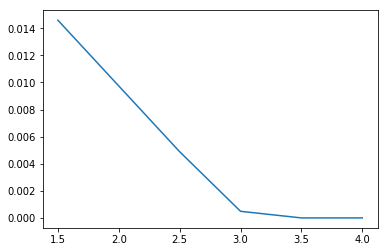

In [154]:
plt.plot(K, p_sim)
plt.show()

In [156]:
# create the associated graphs
ax11.title.set_text("simulated rate paths")
ax11.set_xlabel("time")
ax11.set_ylabel("rate")
ax11.set_xlim([0, T])

ax12.title.set_text("simulated vol paths")
ax12.set_xlabel("time")
ax12.set_ylabel("volatility")
ax12.set_xlim([0, T])
ax12.yaxis.tick_right()
ax12.yaxis.set_label_position("right")

# create the histogram
ax21 = fig.add_subplot(223)
ax22 = fig.add_subplot(224)

binwidth = 0.01
ax21.title.set_text("terminal rate distribution")
ax21.hist(rate_T, bins=np.arange(min(rate_T), max(rate_T) + binwidth, binwidth))
ax21.set_xlabel("rate")

binwidth = 0.01
ax22.title.set_text("terminal vol distribution")
ax22.hist(vol_T, bins=np.arange(min(vol_T), max(vol_T) + binwidth, binwidth))
ax22.set_xlabel("volatility")
fig.tight_layout()
plt.show()

c:\program files\nomura\fingal64\python\python27\lib\site-packages\matplotlib\figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


## The SABR formula
Following Hagan and al., one may use singular perturbation techniques to generate an analytical form approximation of the impled volatility $\sigma_B(f, K)$. The formula is given below:

$$
\sigma_B(f, K) = \frac{\alpha}{(fK)^{(1-\beta)/2}\left\{1+\frac{(1-\beta)^2}{24}\log^2f/K+\frac{(1-\beta)^4}{1920}\log^4f/K+\ldots\right\}}\left(\frac{z}{\aleph(z)}\right)\left\{1+\left[\frac{(1-\beta)^2}{24}\frac{\alpha^2}{(fK)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(fK)^{(1-\beta)/2}} + \frac{2-3\rho^2}{24}\nu^2\right]t_{ex}+\ldots\right\}
$$

where 

$$
z = \frac{\nu}{\alpha}(fK)^{(1-\beta)/2}\log f/K
$$

and $\aleph(z)$ is defined by

$$
\aleph(z) = \log\left\{\frac{\sqrt{1-2\rho z + z^2} + z - \rho}{1-\rho}\right\}
$$

here follow our implementation:

In [123]:
def sigmaSabr(f, K, alpha, beta, rho, eta, t, T):
    
    print('params: f={0}, K = {1}, alpha={2}, beta={3}, rho={4}, eta={5}, T-t={6}'.format(
        f, K, alpha, beta, rho, eta, T-t))
          
    def zFunc(f, K, alpha, beta, rho, eta):
        return eta / alpha * (f * K) ** ((1-beta) / 2) * np.log(f * K)
                
    def aleph(z, rho):
        
        temp = (np.sqrt(1 - 2 * rho * z + z * z) + z - rho) / (1 - rho)
        return np.log(temp)
    
    z = zFunc(f, K, alpha, beta, rho, eta)
    
    denum = np.log(f/K)
    denum = 1 + (1 - beta) ** 2 / 24 * denum ** 2 + (1-beta) ** 4 / 1920 * denum ** 4
    denum = (f * K) ** ((1-beta) / 2) * denum
    
    rhs = (f * K) ** (1-beta)
    rhs = (1 - beta) ** 2 / 24 * alpha ** 2 / rhs + 0.25 * rho * beta * eta * alpha / np.sqrt(rhs) + (2-3 * rho ** 2) / 24 * eta ** 2
    
    return alpha / denum * z / aleph(z, rho) * (1 + rhs * (T-t))
    

In [109]:
sig = [sigmaSabr(f_0, k / 100, a_0, beta, rho, eta, 0, T) for k in K]
print(sig)
param = zip(sig, K)
def callBlack(sigma, f_0, K, t, T):
    
    from scipy.stats import norm
    
    denum = sigma * np.sqrt(T-t)
    d_1 = np.log(f_0 / K)
    d_2 = d_1 - 0.5 * sigma ** 2 * (T - t)
    d_2 /= denum
    d_1 = d_1 + 0.5 * sigma ** 2 * (T - t)
    d_1 /= denum
                           
    return (1 + f_0) ** (-(T - t)) * f_0 * norm.cdf(d_1) - K * norm.cdf(d_2)

res = [callBlack(p[0], f_0, p[1], 0, T) for p in param]
print(res)

params: f=0.03, K = 0.015, alpha=0.001, beta=0.5, rho=0.6, eta=0.9, T-t=1
params: f=0.03, K = 0.02, alpha=0.001, beta=0.5, rho=0.6, eta=0.9, T-t=1
params: f=0.03, K = 0.025, alpha=0.001, beta=0.5, rho=0.6, eta=0.9, T-t=1
params: f=0.03, K = 0.03, alpha=0.001, beta=0.5, rho=0.6, eta=0.9, T-t=1
params: f=0.03, K = 0.035, alpha=0.001, beta=0.5, rho=0.6, eta=0.9, T-t=1
params: f=0.03, K = 0.04, alpha=0.001, beta=0.5, rho=0.6, eta=0.9, T-t=1
[0.99676911401874524, 0.95814656725224512, 0.92731466271745666, 0.90162264806478376, 0.87958781827894361, 0.86029337386196225]
[1.6125171522498084e-06, 2.1671783251930094e-07, 3.3961395003850584e-08, 5.9378986679419229e-09, 1.1281711258728002e-09, 2.28928286029562e-10]
